<a href="https://colab.research.google.com/github/anlianguzova/BI-ML-2023/blob/hw_1/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [ ]:
plt.rcParams['figure.figsize'] = 12, 9
sns.set_style('whitegrid')

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1

In [ ]:
X, y = fetch_openml(name='Fashion-MNIST', return_X_y=True, as_frame=False)

/home/al/Documents/bi/ml/knn_hw/venv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

(-0.5, 27.5, 27.5, -0.5)

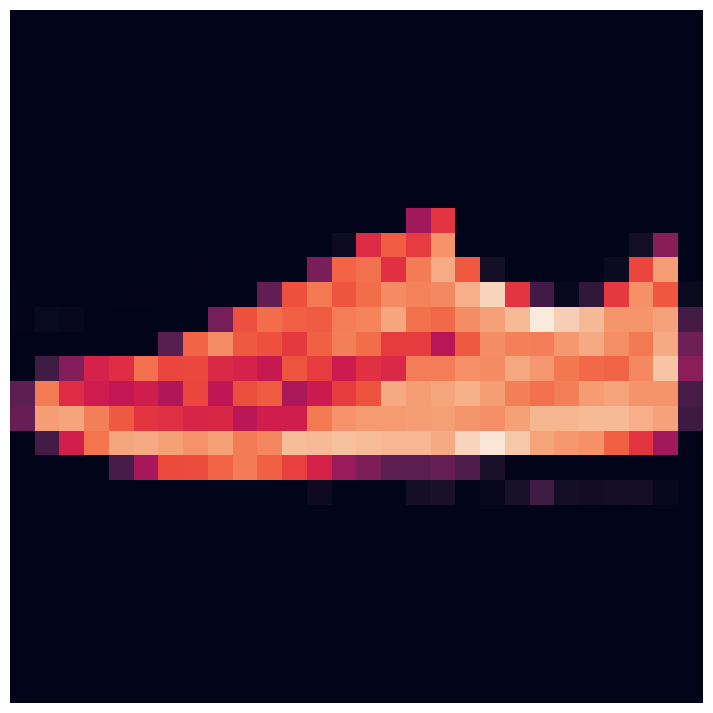

In [ ]:
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis('off')

### 1.1. Посмотрим на все классы (0.5 баллов)

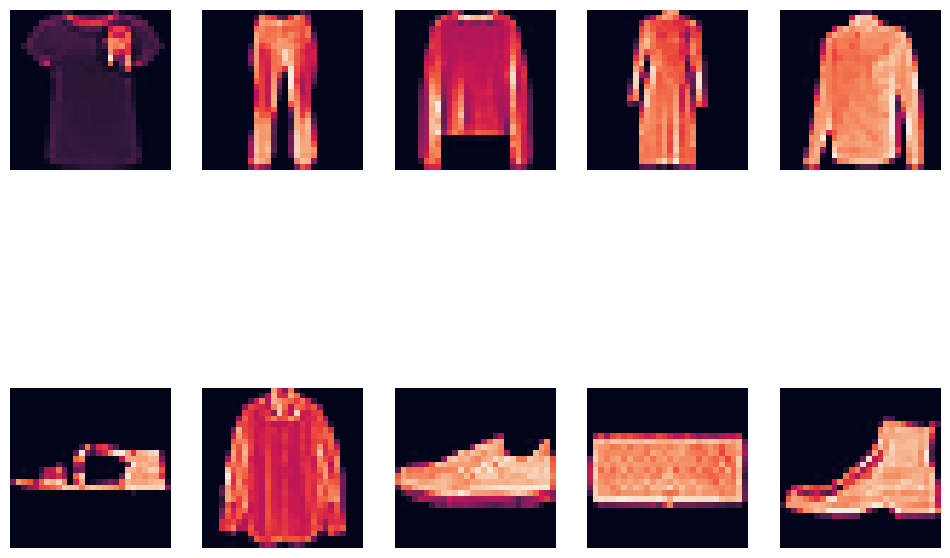

In [ ]:
classes = np.unique(y, return_index=True)
unique_rows = classes[1]

images = X[unique_rows]

fig, axes = plt.subplots(2, 5)

for col in range(len(axes)):
    for row in range(len(axes[col])):
        ind = row if col == 0 else row + 5
        axes[col][row].imshow(images[ind].reshape(28, 28, 1))
        axes[col][row].axis('off')


### 1.2. Сделайте небольшой EDA (1 балл)

<AxesSubplot: ylabel='Count'>

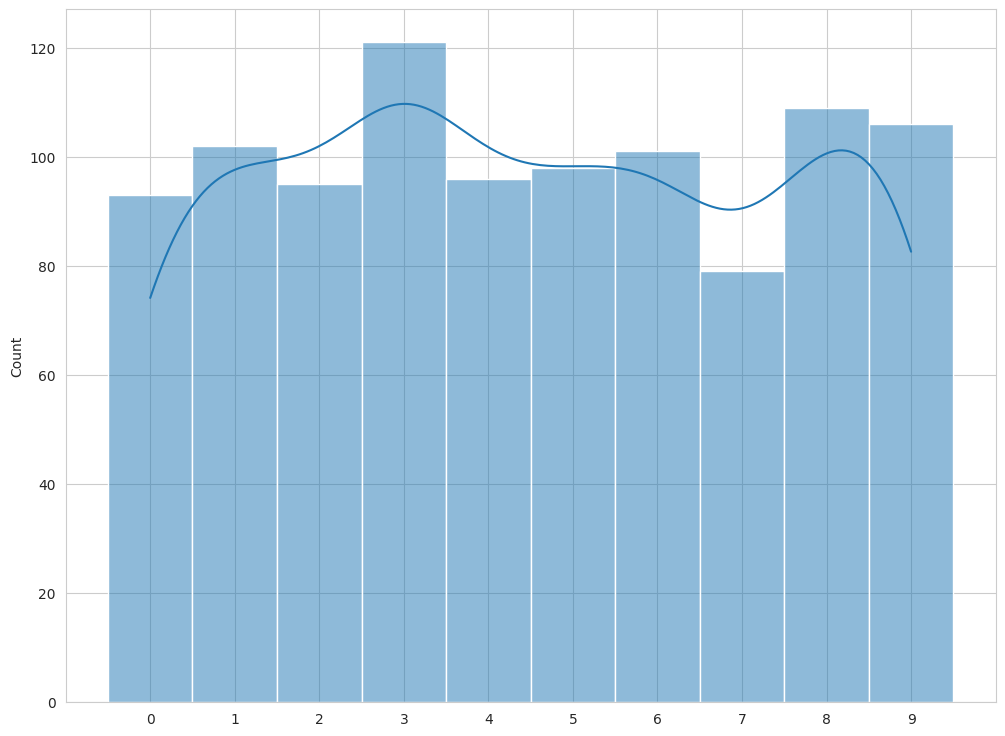

In [ ]:
sns.histplot(sorted(y), kde=True)

Всё ок

### 1.3. Разделите данные на train и test (0.5 баллов)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=SEED,
                                                    test_size=0.2)

### 1.4. KNN для бинарной классификации (6 баллов)

In [ ]:
#indexes
ind_train_y = np.where(y_train.astype(int)<=1)
ind_test_y = np.where(y_test.astype(int)<=1)
#binary X
binary_train_X = X_train[ind_train_y, :][0]
binary_test_X = X_test[ind_test_y, :][0]

#binary Y
binary_train_y = y_train[ind_train_y]
binary_test_y = y_test[ind_test_y]

In [ ]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

#### Distances

In [ ]:
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [ ]:
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [ ]:
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [ ]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X) # the best
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

32.2 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.12 ms ± 7.38 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.4 ms ± 24.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)
print(prediction)

[1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]


#### Metrics

In [ ]:
binary_classification_metrics(prediction, binary_test_y)

(1.0, 1.0, 1.0, 1.0)

как у меня всё здорово и замечательно....

#### Подбор оптимального k

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
def find_best_k(X_train: np.array, y_train: np.array, X_test: np.array, y_test: np.array, params: list, metric) -> tuple:
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics = []
    test_metrics = []

    for k in params:
        knn_classifier = KNNClassifier(k)
        knn_classifier.fit(X_train, y_train)
        train_metrics.append(metric(y_train.astype(int), knn_classifier.predict(X_train)))
        test_metrics.append(metric(y_test.astype(int), knn_classifier.predict(X_test)))

    return train_metrics, test_metrics


In [ ]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, accuracy_score)
train_metrics

[1.0,
 1.0,
 0.9937106918238994,
 0.9937106918238994,
 0.9811320754716981,
 0.9811320754716981,
 0.949685534591195]

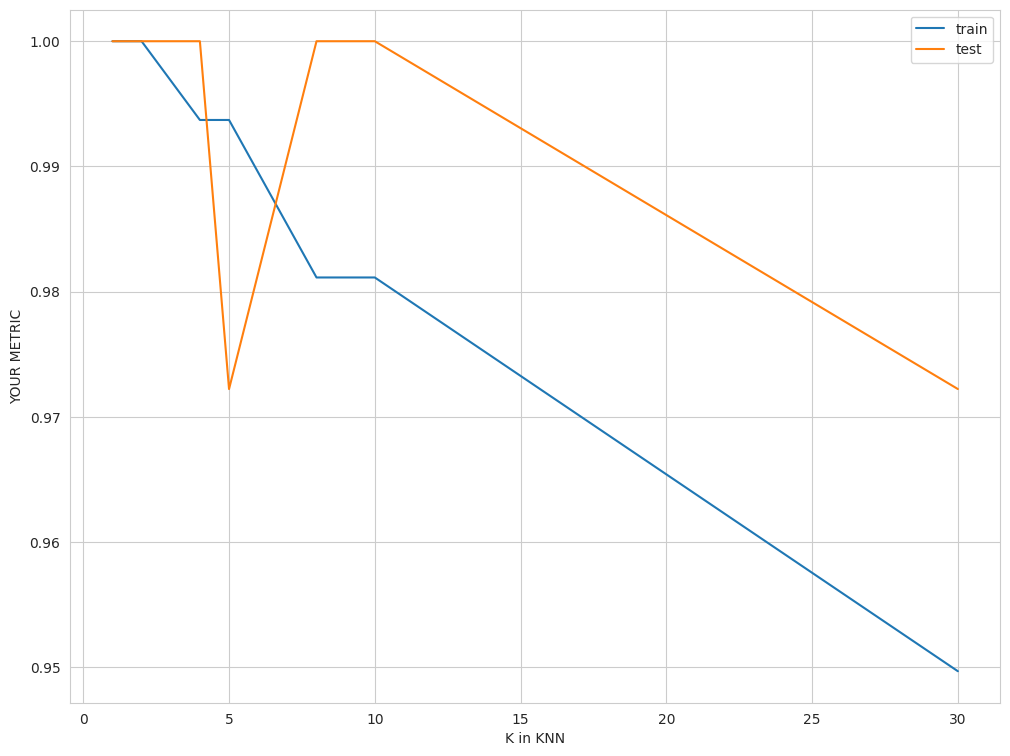

In [ ]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

### 1.5. Многоклассовая классификация (2 балла)

In [ ]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)
predictions

array(['1', '5', '7', '2', '0', '3', '1', '7', '6', '7', '0', '6', '9',
       '4', '0', '6', '8', '4', '9', '7', '9', '8', '1', '9', '9', '9',
       '4', '4', '0', '5', '0', '7', '3', '3', '2', '3', '6', '9', '3',
       '2', '0', '0', '8', '3', '2', '8', '4', '3', '1', '6', '9', '9',
       '2', '4', '5', '4', '1', '7', '4', '8', '5', '4', '1', '2', '7',
       '1', '9', '3', '7', '7', '6', '9', '6', '9', '7', '8', '0', '7',
       '2', '1', '5', '3', '8', '8', '9', '6', '3', '3', '6', '0', '3',
       '4', '5', '9', '6', '3', '7', '4', '6', '5', '2', '4', '5', '5',
       '1', '0', '8', '8', '1', '5', '6', '8', '6', '1', '1', '1', '2',
       '1', '2', '9', '3', '9', '6', '5', '0', '8', '0', '5', '6', '0',
       '2', '2', '8', '2', '3', '9', '9', '2', '4', '8', '2', '1', '0',
       '3', '6', '8', '3', '1', '2', '5', '4', '3', '9', '3', '7', '0',
       '1', '8', '0', '3', '0', '8', '1', '7', '5', '8', '8', '9', '4',
       '1', '7', '3', '6', '9', '6', '6', '2', '8', '6', '2', '9

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию multiclass_accuracy в metrics.py.

In [ ]:
multiclass_accuracy(predictions, y_test)

0.77

In [ ]:
def find_best_multi_k(X_train: np.array, y_train: np.array, X_test: np.array, y_test: np.array, params: list) -> tuple:
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics = []
    test_metrics = []

    for k in params:
        knn_classifier = KNNClassifier(k)
        knn_classifier.fit(X_train, y_train)
        train_metrics.append(multiclass_accuracy(knn_classifier.predict(X_train), y_train.astype(int)))
        test_metrics.append(multiclass_accuracy(knn_classifier.predict(X_test), y_test.astype(int)))

    return train_metrics, test_metrics

In [ ]:
params =  [i for i in range(1,30)]
train_metrics, test_metrics = find_best_multi_k(X_train, y_train, X_test, y_test, params)
train_metrics, test_metrics

([1.0,
  0.88375,
  0.83375,
  0.8,
  0.7825,
  0.78,
  0.755,
  0.74125,
  0.7225,
  0.71375,
  0.71,
  0.69,
  0.685,
  0.68375,
  0.6725,
  0.66,
  0.655,
  0.6525,
  0.6525,
  0.64,
  0.6275,
  0.62875,
  0.625,
  0.61375,
  0.6075,
  0.60625,
  0.60125,
  0.6,
  0.59],
 [0.77,
  0.735,
  0.725,
  0.705,
  0.685,
  0.69,
  0.665,
  0.645,
  0.635,
  0.635,
  0.615,
  0.61,
  0.605,
  0.59,
  0.575,
  0.57,
  0.565,
  0.565,
  0.585,
  0.585,
  0.57,
  0.555,
  0.555,
  0.55,
  0.535,
  0.535,
  0.525,
  0.53,
  0.53])

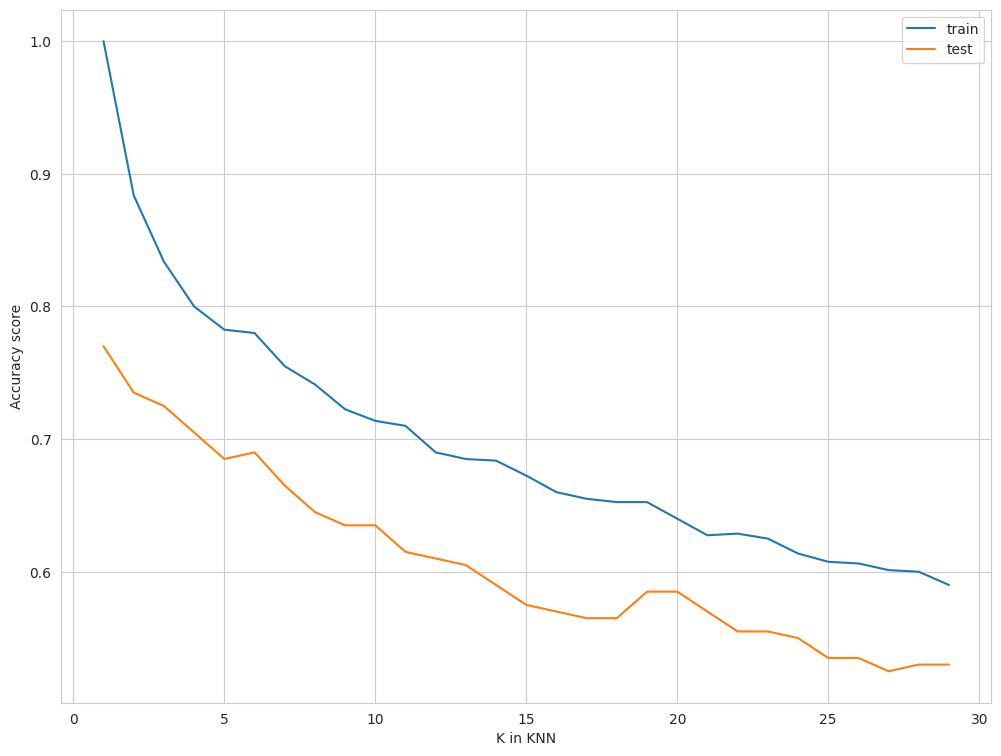

In [ ]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy score");

кажется, k=1 класс

## Задание 2

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [ ]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [ ]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
age,442.0,-2.511817e-19,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.230790e-17,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-2.245564e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,-4.797570e-17,0.047619,-0.112399,-0.036656,-0.005670,0.035644,0.132044
s1,442.0,-1.381499e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,3.918434e-17,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-5.777179e-18,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,-9.042540e-18,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,9.293722e-17,0.047619,-0.126097,-0.033246,-0.001947,0.032432,0.133597
s6,442.0,1.130318e-17,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


In [ ]:
X.isnull().sum()

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

Данные максимально ок выглядят, разве что пара факторов скоррелированы

In [ ]:
X.corr().style.background_gradient(cmap="Blues")

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
age,1.000000,0.173737,0.185085,0.335428,0.260061,0.219243,-0.075181,0.203841,0.270774,0.301731
sex,0.173737,1.000000,0.088161,0.241010,0.035277,0.142637,-0.379090,0.332115,0.149916,0.208133
bmi,0.185085,0.088161,1.000000,0.395411,0.249777,0.261170,-0.366811,0.413807,0.446157,0.388680
bp,0.335428,0.241010,0.395411,1.000000,0.242464,0.185548,-0.178762,0.257650,0.393480,0.390430
s1,0.260061,0.035277,0.249777,0.242464,1.000000,0.896663,0.051519,0.542207,0.515503,0.325717
s2,0.219243,0.142637,0.261170,0.185548,0.896663,1.000000,-0.196455,0.659817,0.318357,0.290600
s3,-0.075181,-0.379090,-0.366811,-0.178762,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697
s4,0.203841,0.332115,0.413807,0.257650,0.542207,0.659817,-0.738493,1.000000,0.617859,0.417212
s5,0.270774,0.149916,0.446157,0.393480,0.515503,0.318357,-0.398577,0.617859,1.000000,0.464669
s6,0.301731,0.208133,0.388680,0.390430,0.325717,0.290600,-0.273697,0.417212,0.464669,1.000000


In [ ]:
from sklearn.pipeline import Pipeline

### 2.2. Регрессионная модель (1 балл)

In [ ]:
y

0      151.0
1       75.0
2      141.0
3      206.0
4      135.0
       ...  
437    178.0
438    104.0
439    132.0
440    220.0
441     57.0
Name: target, Length: 442, dtype: float64

In [ ]:
X_train_diab, X_test_diab, y_train_diab, y_test_diab = train_test_split(X, y, test_size=0.2)

In [ ]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_train_diab, y_train_diab)
predictions = knn.predict(X_test_diab)
predictions

array([118.,  67., 245., 202., 116., 185., 186., 145., 115.,  59.,  75.,
       107.,  53., 118.,  72., 102.,  65., 210., 127., 274., 174., 102.,
        95.,  68.,  53.,  47., 212., 272.,  97., 125., 246., 178., 225.,
       212., 172.,  67.,  39., 219.,  71.,  74.,  79., 321., 185.,  64.,
        53., 212., 111., 155., 296.,  51.,  63., 166., 220., 134.,  59.,
       129., 185., 262.,  31., 253., 206., 185., 126., 225.,  93., 134.,
       163.,  72., 122.,  95.,  95., 214.,  77., 280., 200.,  59., 164.,
       277.,  92., 248., 144., 321., 113., 107., 181.,  53., 181., 175.,
       137.])

### 2.3. Метрики регрессии (3 балла)

In [ ]:
%load_ext autoreload
%autoreload 2

from metrics import r_squared, mae, mse

In [ ]:
r_squared(predictions, y_test_diab), mae(predictions, y_test_diab), mse(predictions, y_test_diab)

(-0.11403890549139795, 55.59550561797753, 5603.438202247191)

### 2.4. Подбор оптимального числа соседей (2 балла)

In [ ]:
r2_score(y_test_diab, predictions), mean_absolute_error(y_test_diab, predictions), mean_squared_error(y_test_diab, predictions)

(-0.11436514818186949, 55.59550561797753, 5603.438202247191)

ура, мои функции всё считают одинаково

In [ ]:
def find_best_reg_k(X_train: np.array, y_train: np.array, X_test: np.array, y_test: np.array, params: list, metric) -> tuple:
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics = []
    test_metrics = []

    for k in params:
        knn_reg = KNeighborsRegressor(k)
        knn_reg.fit(X_train, y_train)
        train_metrics.append(metric(knn_reg.predict(X_train), y_train.astype(int)))
        test_metrics.append(metric(knn_reg.predict(X_test), y_test.astype(int)))

    return train_metrics, test_metrics

In [ ]:
params =  [i for i in range(1,30)]
train_metrics, test_metrics = find_best_reg_k(X_train_diab, y_train_diab, X_test_diab, y_test_diab, params, r2_score)
train_metrics, test_metrics

([1.0,
  0.6831199909879764,
  0.49379855617260315,
  0.36627393073113435,
  0.2682611986779537,
  0.15177370177499983,
  0.07431469496680898,
  0.04580737701714155,
  0.02001549662680957,
  -0.04014022954228191,
  -0.14189141327068944,
  -0.1794443938527186,
  -0.2159863644226805,
  -0.2475520897820227,
  -0.2819933209693739,
  -0.3023025164875037,
  -0.3356808411557781,
  -0.3409757795953081,
  -0.36734610197848183,
  -0.4104495768156764,
  -0.4367044751005056,
  -0.46343150208166084,
  -0.487355795609403,
  -0.5201890933668545,
  -0.5655451602215578,
  -0.5709684970645055,
  -0.5883299996830311,
  -0.6225724733326281,
  -0.6456170776451104],
 [-0.03439446109699773,
  -0.28847709031406965,
  -0.30970255625315324,
  -0.21750672448539543,
  -0.25237479571050025,
  -0.2824886371299078,
  -0.2449771049433711,
  -0.3577687383602872,
  -0.449431539515432,
  -0.42364395306765745,
  -0.40867354101292186,
  -0.4877535947227374,
  -0.46711776460818055,
  -0.5112130352992148,
  -0.5389865493562

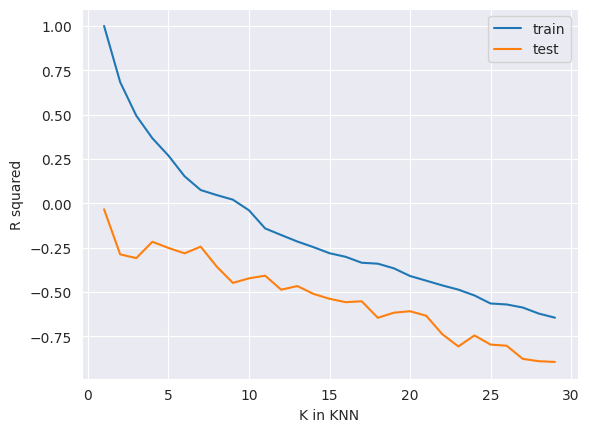

In [ ]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("R squared");

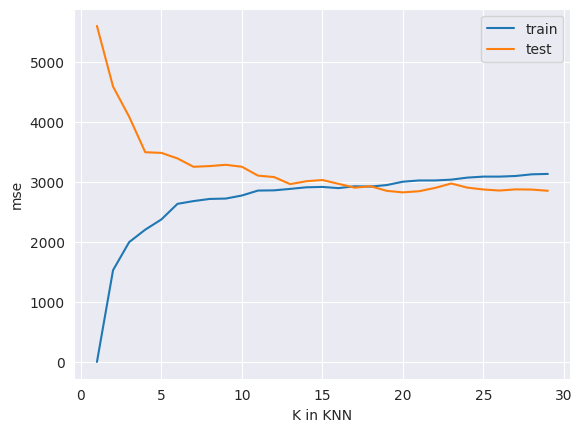

In [ ]:
train_metrics, test_metrics = find_best_reg_k(X_train_diab, y_train_diab, X_test_diab, y_test_diab, params, mse)
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("mse");

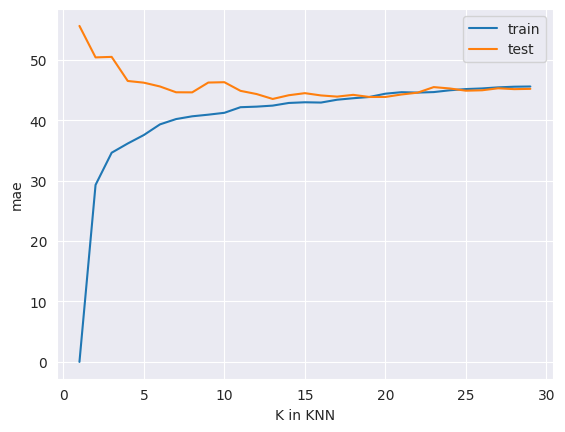

In [ ]:
train_metrics, test_metrics = find_best_reg_k(X_train_diab, y_train_diab, X_test_diab, y_test_diab, params, mae)
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("mae");

## Социализация (0.5 доп. балла)

![screen](https://drive.google.com/uc?id=1566V4cs5WbjsMI0no9EjCgKudjKPu2B-)

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**
в целом задания ок, если бы на лекциях поподробнее был именно код освещён. ну и если бы не неделя была на дз, а чутка побольше